In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
folder_path = '/content/drive/My Drive/question4-stock-data.csv'
raw_data = pd.read_csv(folder_path,index_col=0)

**EDA**

In [4]:
raw_data.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,1980-03-17,2.296798,3.291227,3.344743,3.291227,0.000000,41109.0
1,1980-03-18,2.306134,3.304606,3.358122,3.304606,0.000000,9343.0
2,1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0.0
3,1980-03-20,2.306134,3.304606,3.358122,3.304606,0.000000,10277.0
4,1980-03-21,2.362154,3.384880,3.438396,3.384880,0.000000,8409.0


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11291 entries, 0 to 11290
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       11181 non-null  object 
 1   Adj Close  11198 non-null  float64
 2   Close      11174 non-null  float64
 3   High       11196 non-null  float64
 4   Low        11164 non-null  float64
 5   Open       11188 non-null  float64
 6   Volume     11146 non-null  float64
dtypes: float64(6), object(1)
memory usage: 963.7+ KB


filling missing date values

In [6]:
raw_data['Date'] = raw_data['Date'].fillna(method='ffill')

raw_data['Date'] = pd.to_datetime(raw_data['Date'])

raw_data.loc[raw_data.index[raw_data['Date'].duplicated(keep='first')], 'Date'] += pd.Timedelta(days=1)

raw_data.loc[raw_data.index[raw_data['Date'].duplicated(keep='first')], 'Date'] += pd.Timedelta(days=1)

<ipython-input-6-cb56b2b26236>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  raw_data['Date'] = raw_data['Date'].fillna(method='ffill')


filling missing values with linear interpolation

In [7]:
raw_data['Open'] = raw_data['Open'].interpolate(method='linear')
raw_data['Close'] = raw_data['Close'].interpolate(method='linear')
raw_data['High'] = raw_data['High'].interpolate(method='linear')
raw_data['Adj Close'] = raw_data['Adj Close'].interpolate(method='linear')
raw_data['Low'] = raw_data['Low'].interpolate(method='linear')
raw_data['Volume'] = raw_data['Volume'].interpolate(method='linear')

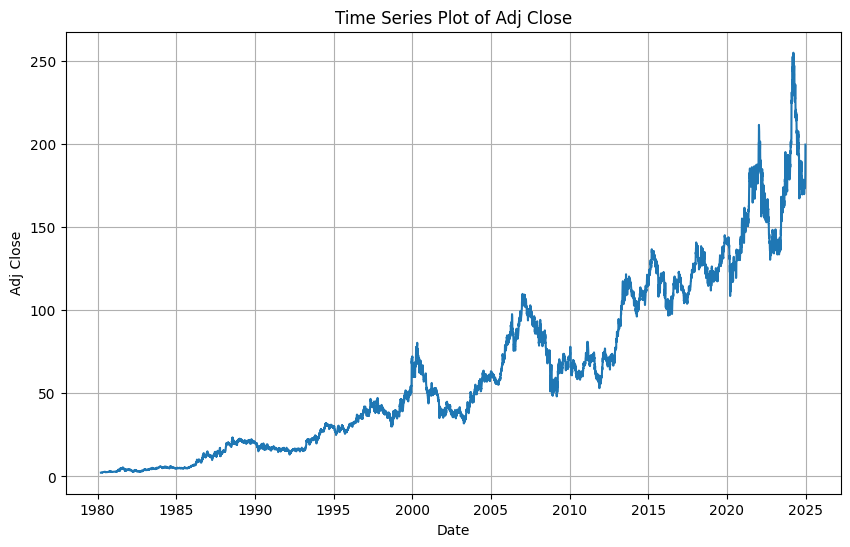

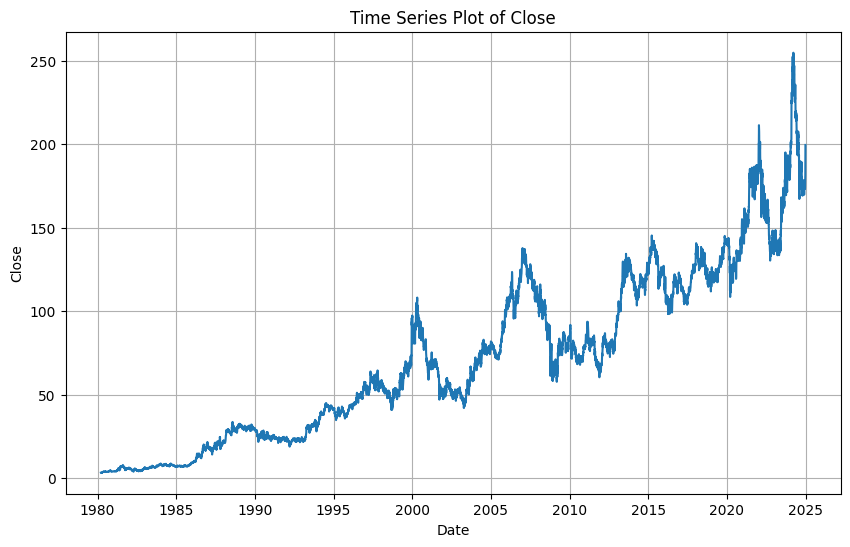

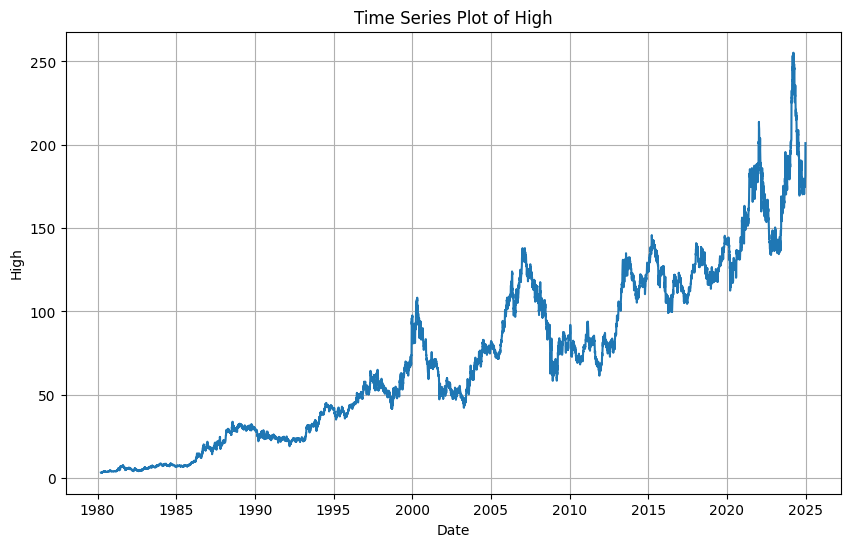

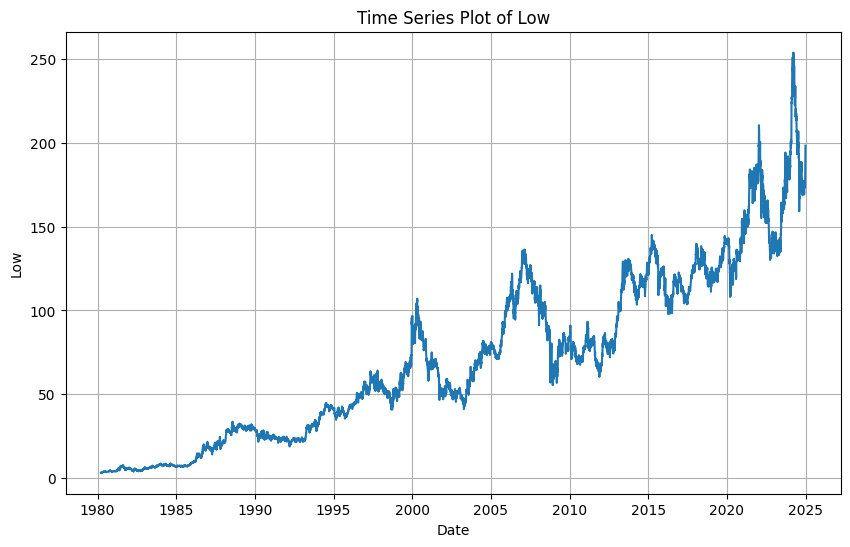

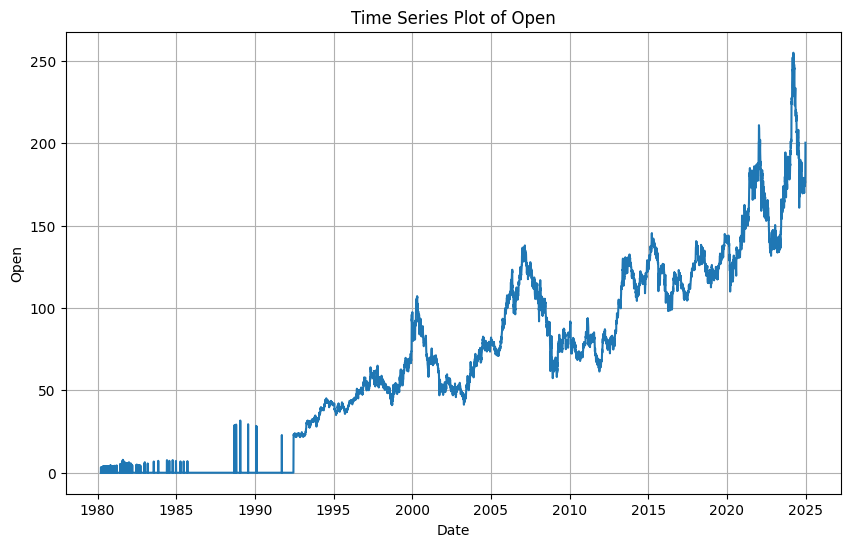

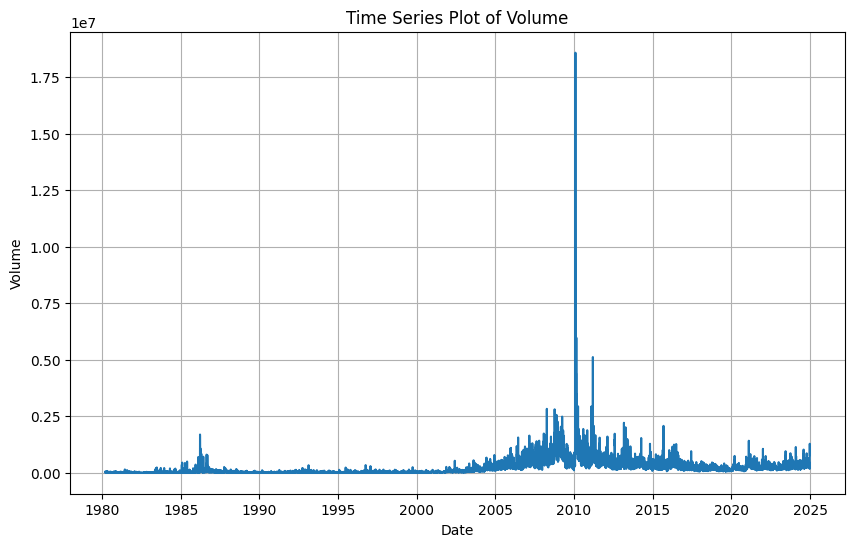

In [8]:

for column in raw_data.columns:
    if column != 'Date':
        plt.figure(figsize=(10, 6))
        plt.plot(raw_data['Date'], raw_data[column])
        plt.xlabel('Date')
        plt.ylabel(column)
        plt.title(f'Time Series Plot of {column}')
        plt.grid(True)
        plt.show()


unusual spikes in Volumes 2010

Stationary Check

In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(raw_data['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -0.44290839689492084
p-value: 0.9026843620463811


<Figure size 10000x10000 with 0 Axes>

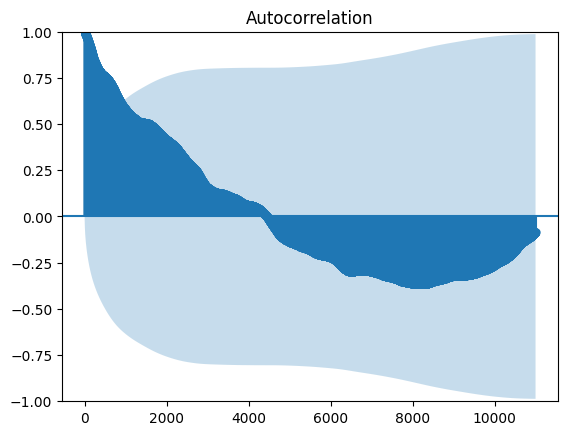

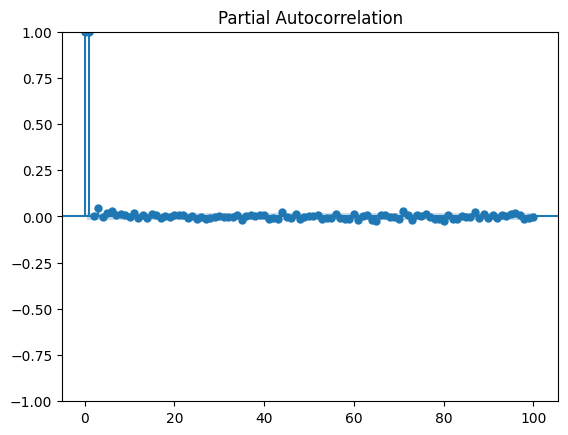

In [33]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(100, 100))
plot_acf(raw_data['Close'],lags=11000)
plot_pacf(raw_data['Close'],lags=100)
plt.show()


In [35]:
raw_data['Close - Open'] = raw_data['Close'] - raw_data['Open']

new_df = raw_data.copy()

new_df.head()


        Date  Adj Close     Close      High       Low      Open   Volume  \
0 1980-03-17   2.296798  3.291227  3.344743  3.291227  0.000000  41109.0   
1 1980-03-18   2.306134  3.304606  3.358122  3.304606  0.000000   9343.0   
2 1980-03-19   2.306134  3.304606  3.304606  3.304606  3.304606      0.0   
3 1980-03-20   2.306134  3.304606  3.358122  3.304606  0.000000  10277.0   
4 1980-03-21   2.362154  3.384880  3.438396  3.384880  0.000000   8409.0   

   Close - Open  
0      3.291227  
1      3.304606  
2      0.000000  
3      3.304606  
4      3.384880  


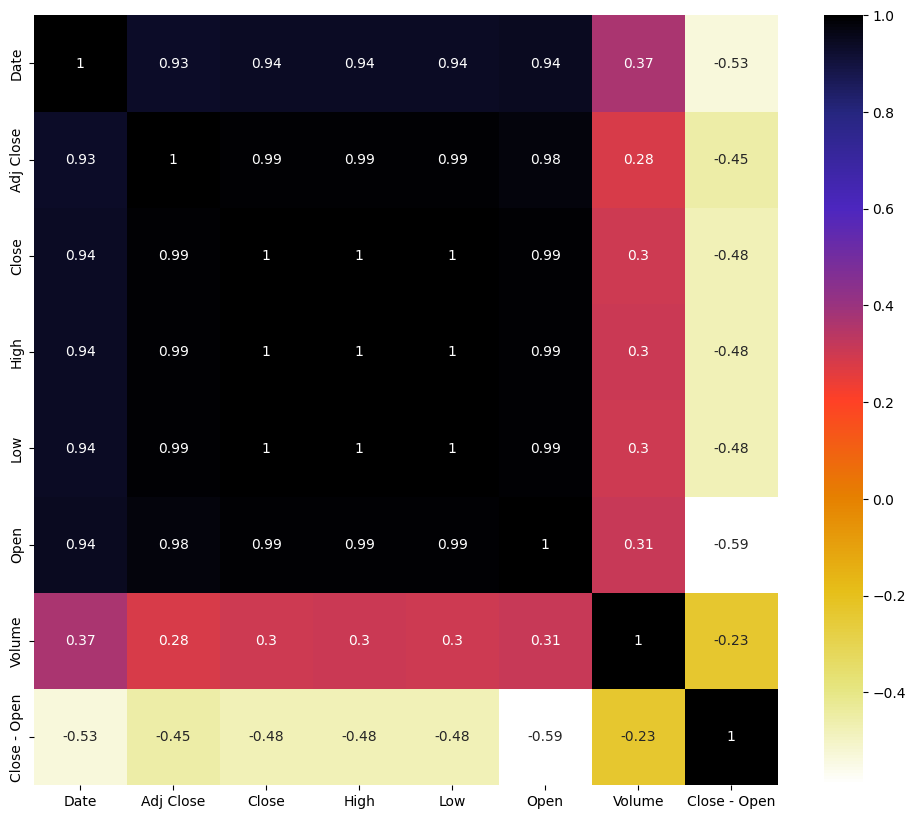

In [36]:
plt.figure(figsize=(12, 10))
cor = raw_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()


In [39]:
for i in range(1, 41):
    new_df[f'lag_{i}'] = new_df['Close'].shift(i)

new_df['diff_1'] = new_df['Close'].diff(1)

new_df['rolling_mean_10'] = new_df['Close'].rolling(window=10).mean()
new_df['rolling_std_10'] = new_df['Close'].rolling(window=10).std()
new_df['rolling_mean_40'] = new_df['Close'].rolling(window=40).mean()

new_df['ema_10'] = new_df['Close'].ewm(span=10, adjust=False).mean()
new_df['ema_40'] = new_df['Close'].ewm(span=40, adjust=False).mean()

new_df['month'] = new_df['Date'].dt.month
new_df['day'] = new_df['Date'].dt.day
new_df['weekday'] = new_df['Date'].dt.weekday

new_df.dropna(inplace=True)



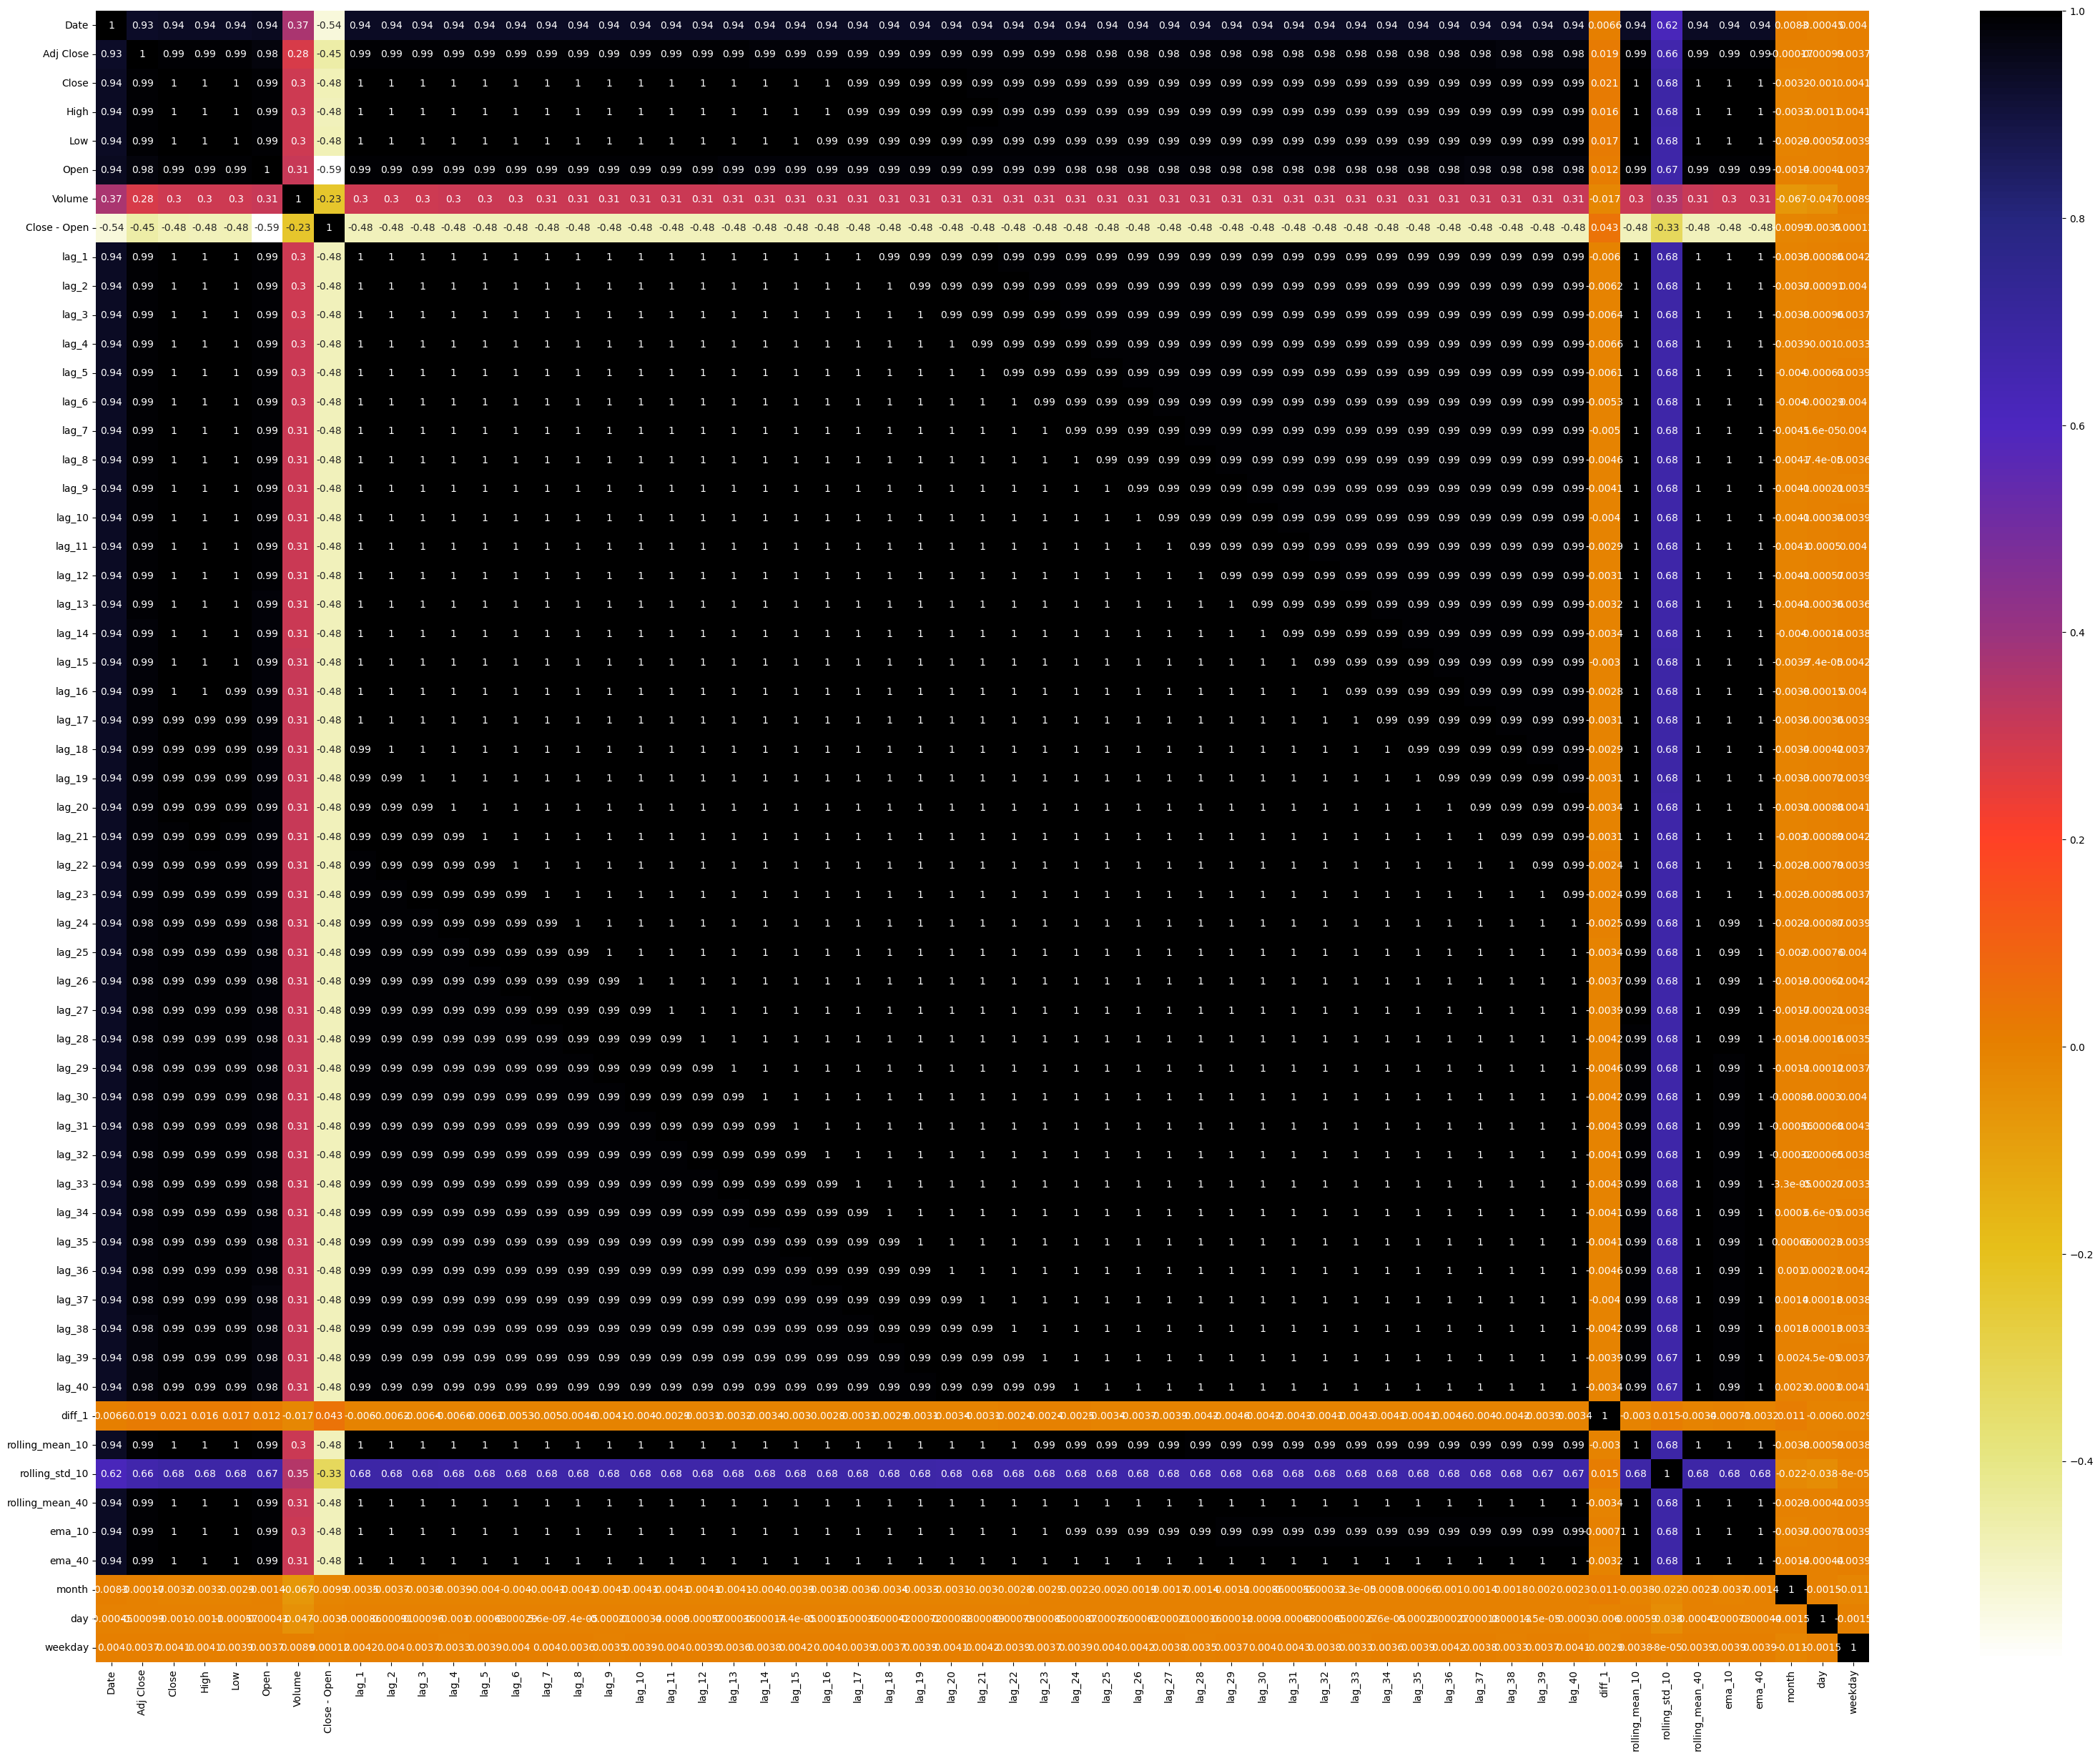

In [41]:
plt.figure(figsize=(40, 30))
cor = new_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from math import sqrt

In [45]:
print(new_df.columns)

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'Close - Open', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13',
       'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20',
       'lag_21', 'lag_22', 'lag_23', 'lag_24', 'lag_25', 'lag_26', 'lag_27',
       'lag_28', 'lag_29', 'lag_30', 'lag_31', 'lag_32', 'lag_33', 'lag_34',
       'lag_35', 'lag_36', 'lag_37', 'lag_38', 'lag_39', 'lag_40', 'diff_1',
       'rolling_mean_10', 'rolling_std_10', 'rolling_mean_40', 'ema_10',
       'ema_40', 'month', 'day', 'weekday'],
      dtype='object')


In [63]:
X = new_df[['Adj Close','High', 'Low', 'Open',#'Volume','Close - Open','diff_1',
            'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13',
       'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20',
       'lag_21', 'lag_22', 'lag_23', 'lag_24', 'lag_25', 'lag_26', 'lag_27',
       'lag_28', 'lag_29', 'lag_30', 'lag_31', 'lag_32', 'lag_33', 'lag_34',
       'lag_35', 'lag_36', 'lag_37', 'lag_38', 'lag_39', 'lag_40',
       'rolling_mean_10', 'rolling_std_10', 'rolling_mean_40', 'ema_10',
       'ema_40', 'month', 'day', 'weekday']]
y = new_df['Close']


In [103]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)


In [104]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.04, max_depth=6)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [105]:
y_pred = model.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')


RMSE: 16.465015738147194


In [106]:
future_preds = []
last_data = X.iloc[-1, :].values.reshape(1, -1)  # Last known data point

for _ in range(5):
    pred = model.predict(last_data)[0]  # Predict the next value
    future_preds.append(pred)

    # Update last_data with the predicted Close value and shift lags
    new_data = np.roll(last_data, shift=-1, axis=1)  # Shift the data to the left
    new_data[0, -1] = pred  # Replace the last column with the new predicted Close
    last_data = new_data  # Update for next iteration

print("Predicted future Close values:", future_preds)


Predicted future Close values: [195.97435, 197.68045, 183.98671, 182.95375, 181.94032]


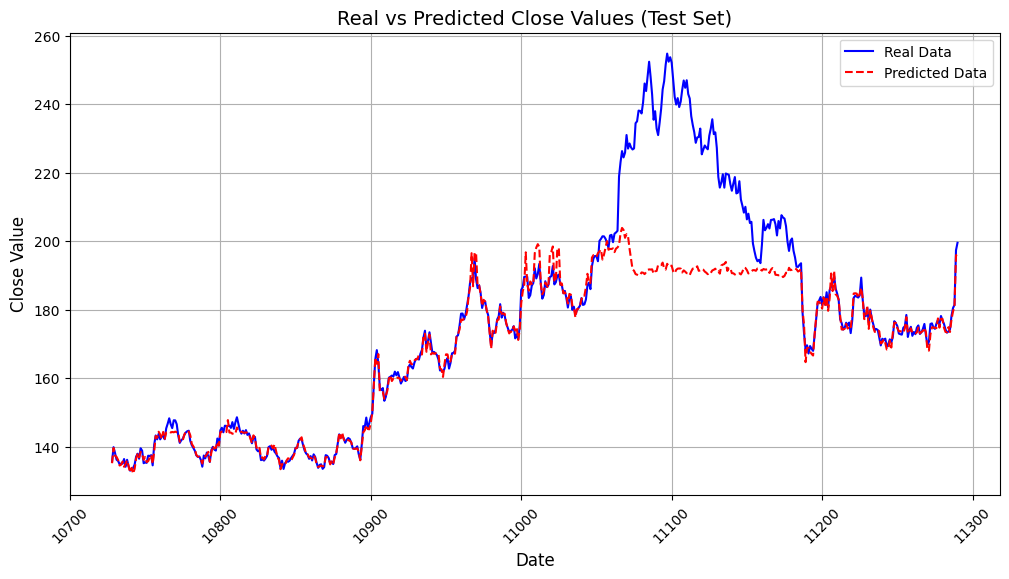

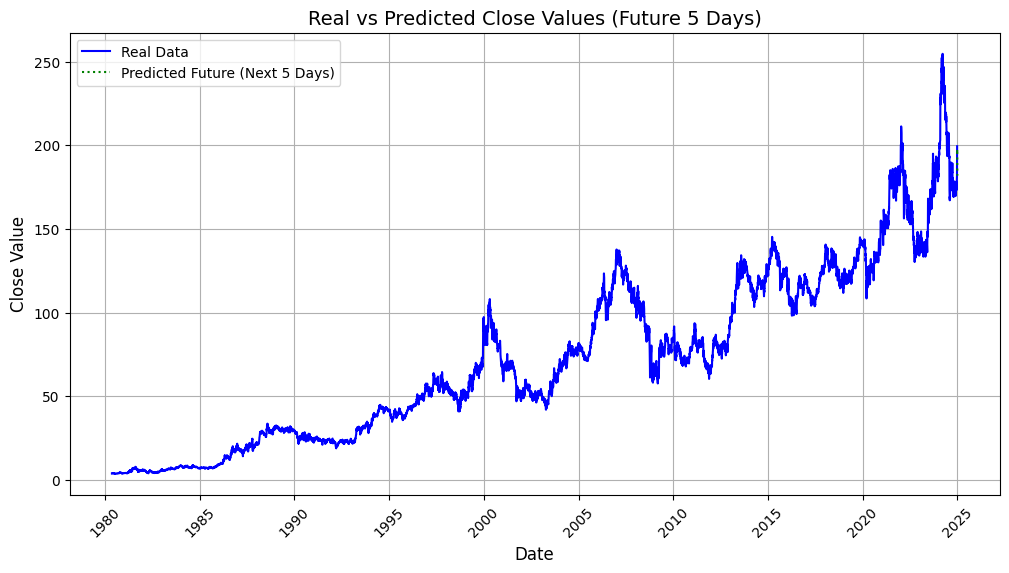

In [107]:

# 1. Plot Real Data vs Predicted Data on Test Set

# Plot actual vs predicted values for the test set
plt.figure(figsize=(12, 6))

# Plot the actual values (test data)
plt.plot(y_test.index, y_test, label='Real Data', color='blue')

# Plot the predicted values (test data)
plt.plot(y_test.index, y_pred, label='Predicted Data', color='red', linestyle='--')

plt.title('Real vs Predicted Close Values (Test Set)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# 2. Plot Real Data vs Predicted Future Values (Next 5 days)

# You can use the last date of the dataset to create future dates for plotting
last_date = new_df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=6, freq='D')[1:]  # The next 5 days

# Plot the real data up to the last known date
plt.figure(figsize=(12, 6))
plt.plot(new_df['Date'], new_df['Close'], label='Real Data', color='blue')

# Plot the predicted future values
plt.plot(future_dates, future_preds, label='Predicted Future (Next 5 Days)', color='green', linestyle=':')

plt.title('Real vs Predicted Close Values (Future 5 Days)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


zoom into the plot to view the graphs

In [93]:
data = raw_data.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

10727

In [94]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


In [95]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(40, len(train_data)):
    x_train.append(train_data[i-40:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 41:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.00021276, 0.00026595, 0.00026595, 0.00026595, 0.00058509,
       0.00063828, 0.0005319 , 0.0005319 , 0.00037233, 0.00031914,
       0.00031914, 0.00010638, 0.        , 0.        , 0.        ,
       0.        , 0.00042552, 0.00058509, 0.0005319 , 0.0005319 ,
       0.00095742, 0.00095742, 0.00095742, 0.00074466, 0.00074466,
       0.00074466, 0.00101061, 0.00111699, 0.00122337, 0.00138294,
       0.0015957 , 0.00164889, 0.00170208, 0.00170208, 0.00180846,
       0.0021276 , 0.0021276 , 0.00218079, 0.00223398, 0.00255312])]
[0.0025531152459778543]

[array([0.00021276, 0.00026595, 0.00026595, 0.00026595, 0.00058509,
       0.00063828, 0.0005319 , 0.0005319 , 0.00037233, 0.00031914,
       0.00031914, 0.00010638, 0.        , 0.        , 0.        ,
       0.        , 0.00042552, 0.00058509, 0.0005319 , 0.0005319 ,
       0.00095742, 0.00095742, 0.00095742, 0.00074466, 0.00074466,
       0.00074466, 0.00101061, 0.00111699, 0.00122337, 0.00138294,
       0.0015957 , 0.00164889, 0.

In [96]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10687/10687 ━━━━━━━━━━━━━━━━━━━━ 426s 39ms/step - loss: 6.9928e-04


In [97]:
test_data = scaled_data[training_data_len - 40: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(40, len(test_data)):
    x_test.append(test_data[i-40:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step


3.0897839543003474

<ipython-input-98-bac245597b66>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


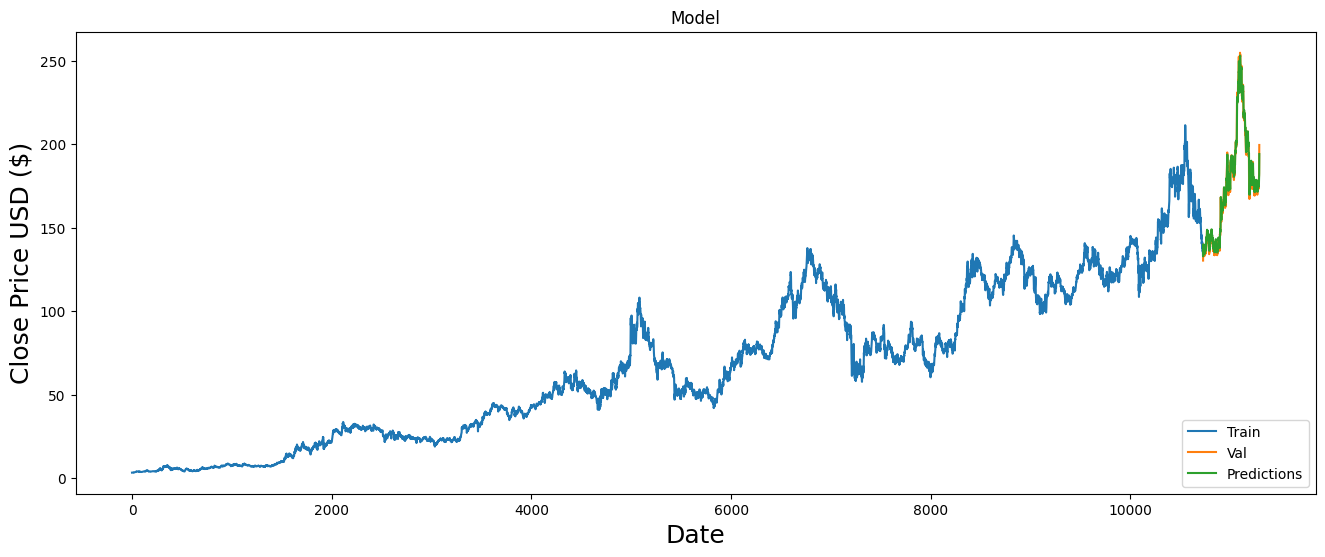

In [98]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [100]:

# Get the last 40 days of data for prediction
last_40_days = scaled_data[-40:]  # Taking the last 40 days of scaled data
predicted_prices = []

for _ in range(5):  # Predicting for the next 5 days
    # Reshape the input to match LSTM's required shape: (samples, time steps, features)
    input_data = np.reshape(last_40_days, (1, last_40_days.shape[0], 1))

    # Predict the next day's price
    next_day_pred = model.predict(input_data)

    # Inverse transform to get the actual price
    next_day_pred_actual = scaler.inverse_transform(next_day_pred)[0, 0]

    # Append the prediction to the list
    predicted_prices.append(next_day_pred_actual)

    # Update the input sequence: Remove the first value and append the predicted value
    next_day_scaled = scaler.transform([[next_day_pred_actual]])[0, 0]  # Scale the new prediction
    last_40_days = np.append(last_40_days[1:], next_day_scaled).reshape(-1, 1)

# Print or store the 5-day forecasted prices
print("Predicted stock prices for the next 5 days:", predicted_prices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Predicted stock prices for the next 5 days: [199.7216, 200.73466, 200.88618, 200.62195, 200.19656]


In [108]:
# prompt: create new dataframe using predicted_prices and future preds list

# Create a new DataFrame
future_df = pd.DataFrame({'Predicted_Close_LSTM': predicted_prices,
                         'Predicted_Close_XGB': future_preds})

future_df


,Predicted_Close_LSTM,Predicted_Close_XGB
0,199.721603,195.974350
1,200.734665,197.680450
2,200.886185,183.986710
3,200.621948,182.953751
4,200.196564,181.940323
